# Content-Based Music Recommendation System

Qinan Ji (z5399710)

The task is to build a content-based “music recommender” such as might be used by a streaming service (such as Spotify) to give users a personalized playlist of songs that match their interests.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

## Dataset Overview
- 1500 songs with 6 fields: artist_name, track_name, release_date, genre, lyrics, topic
- 5 topics: dark, emotion, lifestyle, personal, sadness
- User profiles: User1 and User2 with topic-specific keywords

In [2]:
# Load and explore the dataset
df = pd.read_csv('dataset.tsv', sep='\t')
user1_df = pd.read_csv('user1.tsv', sep='\t')
user2_df = pd.read_csv('user2.tsv', sep='\t')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nTopic distribution:")
print(df['topic'].value_counts())

print("\nUser 1 preferences:")
print(user1_df)

print("\nUser 2 preferences:")
print(user2_df)


Dataset shape: (1500, 6)

First few rows:
                            artist_name         track_name  release_date  \
0                                loving  the not real lake          2016   
1                               incubus    into the summer          2019   
2                             reignwolf           hardcore          2016   
3                  tedeschi trucks band             anyhow          2016   
4  lukas nelson and promise of the real  if i started over          2017   

   genre                                             lyrics      topic  
0   rock  awake know go see time clear world mirror worl...       dark  
1   rock  shouldn summer pretty build spill ready overfl...  lifestyle  
2  blues  lose deep catch breath think say try break wal...    sadness  
3  blues  run bitter taste take rest feel anchor soul pl...    sadness  
4  blues  think think different set apart sober mind sym...       dark  

Topic distribution:
topic
dark         490
sadness      376
pe

# Part 1: Topic Classification

## Question 1: Text Preprocessing

The tutorial code removes too many special characters. Some symbols like !, ?, and . can show strong emotion, which is useful for topic classification. So I changed the cleaning function to only remove symbols that are not helpful, and keep important ones. I also used lemmatization (not stemming), so words like “crying” become “cry” instead of “cri”. This keeps the meaning clear.

The tutorial only used one train-test split, which can be unstable. I changed it to use 5-fold cross-validation. This gives more reliable results and uses all the data for both training and testing.

Key Points:

- Keep emotional symbols: Keep "!", "?", "." for sentiment context
- More gentle regex: Remove only truly disruptive punctuation
- POS tagging assistance: Use linguistic structure to guide processing
- Lemmatization: Maintain semantic meaning

Instead of single train-test split, I use K-fold cross-validation to:
- Reduce data partition bias
- Get more stable performance estimates  
- Better assess generalization capability
- Particularly important for smaller datasets (1500 songs)


In [3]:
# Create document by concatenating all song information
def create_document(row):
    """Concatenate all song information into a single document"""
    doc = f"{row['artist_name']} {row['track_name']} {row['release_date']} {row['genre']} {row['lyrics']}"
    return doc

# Add document column
df['document'] = df.apply(create_document, axis=1)

print("Sample document:")
print(df['document'].iloc[0][:200] + "...")
print(f"\nDocument lengths \n Mean: {df['document'].str.len().mean():.0f}, Max: {df['document'].str.len().max()}")


Sample document:
loving the not real lake 2016 rock awake know go see time clear world mirror world mirror magic hour confuse power steal word unheard unheard certain forget bless angry weather head angry weather head...

Document lengths 
 Mean: 511, Max: 1468


In [4]:
# Text preprocessing functions
def gentle_clean_text(text):
    """Gentle cleaning that preserves emotional symbols"""
    # Convert to lowercase
    text = text.lower()
    # Remove only specific unwanted characters, keep emotional punctuation
    text = re.sub(r'[^\w\s!?.]', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def aggressive_clean_text(text):
    """Aggressive cleaning similar to tutorial approach"""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))


## Question 2: Bernoulli & Multinomial Naive Bayes Models

I tested different text preprocessing steps. The best performance came from this pipeline:

- Lowercase all text
- Gentle regex: remove unhelpful punctuation, keep emotional ones
- Tokenize words
- Remove stopwords (using NLTK)
- Lemmatize words (not stem)

This method gave the best results for both BNB and MNB models. I will use this same preprocessing for all future steps.

In [5]:
def preprocess_text(text, method='optimal'):
    """Apply different preprocessing methods"""
    if method == 'aggressive':
        text = aggressive_clean_text(text)
    else:
        text = gentle_clean_text(text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    
    # Apply lemmatization
    if method == 'optimal':
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    else:
        tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(tokens)

# Test preprocessing methods
sample_text = df['document'].iloc[0]
print("Original:", sample_text[:100])
print("Gentle:", preprocess_text(sample_text, 'gentle')[:100])
print("Optimal:", preprocess_text(sample_text, 'optimal')[:100])

Original: loving the not real lake 2016 rock awake know go see time clear world mirror world mirror magic hour
Gentle: love real lake 2016 rock awak know go see time clear world mirror world mirror magic hour confus pow
Optimal: loving real lake 2016 rock awake know go see time clear world mirror world mirror magic hour confuse


In [6]:
# Apply optimal preprocessing to all documents
df['processed_document'] = df['document'].apply(lambda x: preprocess_text(x, 'optimal'))

# Prepare data for modeling
X = df['processed_document']
y = df['topic']

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Data prepared for modeling")
print(f"Number of samples: {len(X)}")
print(f"Topic distribution:\n{y.value_counts()}")

# Check class balance
topic_counts = y.value_counts()
print(f"\nClass balance ratio: {topic_counts.min()/topic_counts.max():.2f}")


Data prepared for modeling
Number of samples: 1500
Topic distribution:
topic
dark         490
sadness      376
personal     347
lifestyle    205
emotion       82
Name: count, dtype: int64

Class balance ratio: 0.17


In [7]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score

# Function to evaluate models with cross-validation and detailed metrics
def evaluate_model_detailed(model, vectorizer, X, y, cv, model_name):
    """Evaluate model using cross-validation with detailed metrics"""
    # Transform text to features
    X_vectorized = vectorizer.fit_transform(X)
    
    # Define scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
        'recall_macro': make_scorer(recall_score, average='macro', zero_division=0)
    }
    
    # Cross-validation with multiple metrics
    cv_results = cross_validate(model, X_vectorized, y, cv=cv, scoring=scoring)
    
    results = {
        'model': model_name,
        'accuracy_mean': cv_results['test_accuracy'].mean(),
        'accuracy_std': cv_results['test_accuracy'].std(),
        'f1_mean': cv_results['test_f1_macro'].mean(),
        'f1_std': cv_results['test_f1_macro'].std(),
        'precision_mean': cv_results['test_precision_macro'].mean(),
        'precision_std': cv_results['test_precision_macro'].std(),
        'recall_mean': cv_results['test_recall_macro'].mean(),
        'recall_std': cv_results['test_recall_macro'].std()
    }
    
    return results, X_vectorized

# Test different feature extraction approaches
vectorizers = {
    'Binary (BNB)': CountVectorizer(binary=True, max_features=1000),
    'Count (MNB)': CountVectorizer(binary=False, max_features=1000)
}

results = []

# Compare BNB with binary features
bnb_results, X_binary = evaluate_model_detailed(
    BernoulliNB(), vectorizers['Binary (BNB)'], X, y, cv, 'Bernoulli NB'
)
results.append(bnb_results)

# Compare MNB with count features  
mnb_results, X_count = evaluate_model_detailed(
    MultinomialNB(), vectorizers['Count (MNB)'], X, y, cv, 'Multinomial NB'
)
results.append(mnb_results)

# Display results
results_df = pd.DataFrame(results)
print("Model Comparison Results:")
print(results_df[['model', 'accuracy_mean', 'accuracy_std', 'f1_mean', 'f1_std', 
                  'precision_mean', 'precision_std', 'recall_mean', 'recall_std']].round(4))


Model Comparison Results:
            model  accuracy_mean  accuracy_std  f1_mean  f1_std  \
0    Bernoulli NB         0.6280        0.0220   0.5292  0.0285   
1  Multinomial NB         0.8387        0.0171   0.8153  0.0240   

   precision_mean  precision_std  recall_mean  recall_std  
0          0.5512         0.0512       0.5297      0.0258  
1          0.8284         0.0170       0.8079      0.0328  


## Question 3: Bernoulli vs Multinomial Naive Bayes Comparison

I compared Bernoulli Naive Bayes (BNB) and Multinomial Naive Bayes (MNB) using 5-fold cross-validation. The metrics used were accuracy, macro-F1, macro-precision, and macro-recall.

Since the dataset is imbalanced (some topics like "emotion" have fewer songs), accuracy is not enough for comparison. Macro-F1 is better because it gives equal weight to all classes and combines both precision and recall.

The results show that MNB is clearly better in every metric:
- Accuracy: 0.839 vs 0.628
- Macro-F1: 0.815 ± 0.024 vs 0.529 ± 0.029
- Macro-Precision: 0.828 vs 0.551
- Macro-Recall: 0.808 vs 0.530

Conclusion: Multinomial NB is the better model and will be used as the main classifier in later parts.


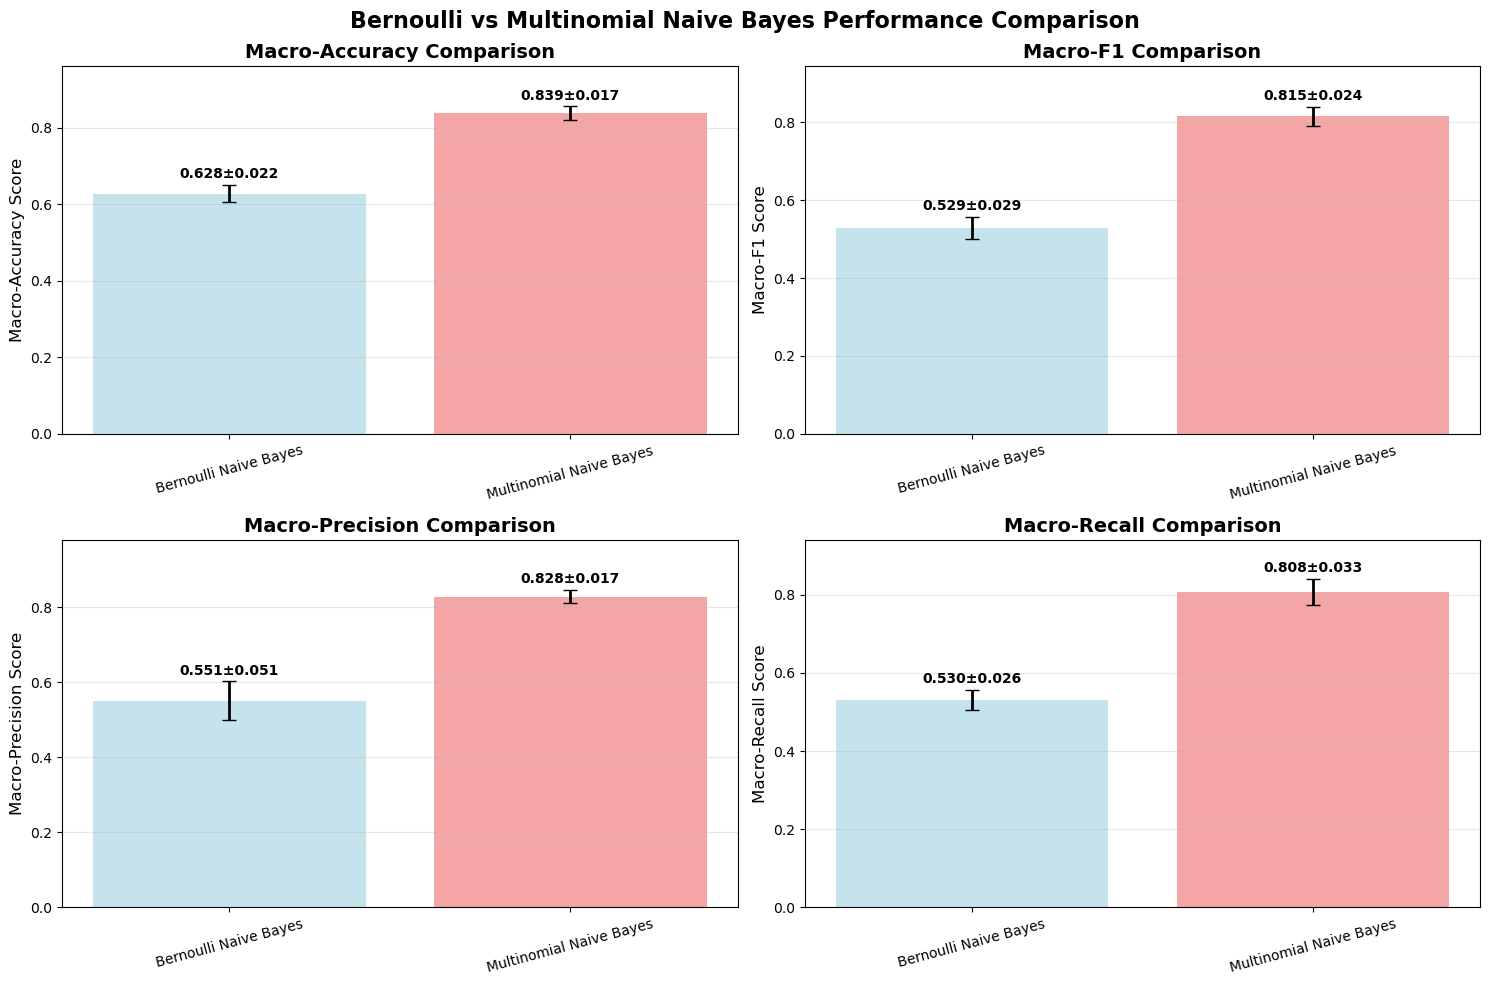

PERFORMANCE SUMMARY
Bernoulli NB  - Accuracy: 0.628±0.022, F1: 0.529±0.029
Multinomial NB - Accuracy: 0.839±0.017, F1: 0.815±0.024
Conclusion: Multinomial NB is better.


In [8]:
# Create performance comparison visualization
def create_performance_comparison():
    """Create bar plots comparing BNB vs MNB performance"""
    
    # Extract data from results
    bnb_data = results_df[results_df['model'] == 'Bernoulli NB'].iloc[0]
    mnb_data = results_df[results_df['model'] == 'Multinomial NB'].iloc[0]
    
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    metric_titles = ['Macro-Accuracy Comparison', 'Macro-F1 Comparison', 
                     'Macro-Precision Comparison', 'Macro-Recall Comparison']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    colors = ['lightblue', 'lightcoral']
    models = ['Bernoulli Naive Bayes', 'Multinomial Naive Bayes']
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Get values and errors
        bnb_mean = bnb_data[f'{metric}_mean']
        bnb_std = bnb_data[f'{metric}_std']
        mnb_mean = mnb_data[f'{metric}_mean']
        mnb_std = mnb_data[f'{metric}_std']
        
        values = [bnb_mean, mnb_mean]
        errors = [bnb_std, mnb_std]
        
        # Create bar plot
        bars = ax.bar(models, values, color=colors, alpha=0.7, 
                      capsize=5, error_kw={'linewidth': 2})
        ax.errorbar(models, values, yerr=errors, fmt='none', 
                   color='black', capsize=5, linewidth=2)
        
        # Add value labels on bars
        for j, (bar, value, error) in enumerate(zip(bars, values, errors)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + error + 0.01,
                   f'{value:.3f}±{error:.3f}', ha='center', va='bottom', 
                   fontweight='bold', fontsize=10)
        
        ax.set_title(metric_titles[i], fontsize=14, fontweight='bold')
        ax.set_ylabel(f'Macro-{metric.capitalize()} Score', fontsize=12)
        ax.set_ylim(0, max(values) + max(errors) + 0.1)
        ax.grid(axis='y', alpha=0.3)
        
        # Rotate x-axis labels if needed
        ax.tick_params(axis='x', rotation=15)
    
    plt.suptitle('Bernoulli vs Multinomial Naive Bayes Performance Comparison', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# Create the visualization
create_performance_comparison()

# Print summary comparison
print("PERFORMANCE SUMMARY")
print(f"Bernoulli NB  - Accuracy: {bnb_results['accuracy_mean']:.3f}±{bnb_results['accuracy_std']:.3f}, "
      f"F1: {bnb_results['f1_mean']:.3f}±{bnb_results['f1_std']:.3f}")
print(f"Multinomial NB - Accuracy: {mnb_results['accuracy_mean']:.3f}±{mnb_results['accuracy_std']:.3f}, "
      f"F1: {mnb_results['f1_mean']:.3f}±{mnb_results['f1_std']:.3f}")

# Determine which model is better
if mnb_results['f1_mean'] > bnb_results['f1_mean']:
    winner = "Multinomial NB"
    advantage = mnb_results['f1_mean'] - bnb_results['f1_mean']
else:
    winner = "Bernoulli NB" 
    advantage = bnb_results['f1_mean'] - mnb_results['f1_mean']

print(f"Conclusion: {winner} is better.")


## Question 4: Feature Number Impact Analysis

I tested different vocabulary sizes (`max_features`) in `CountVectorizer` to see how the number of features affects classification performance. I tested values from 100 to 1000, as well as using all available words (None).

I applied the same preprocessing and evaluated both Bernoulli Naive Bayes (BNB) and Multinomial Naive Bayes (MNB) using 5-fold cross-validation. I compared accuracy and macro-F1 scores for each configuration.

The results show that for both models, performance improves at first but drops when the vocabulary becomes too large. For **MNB**, the best performance is at `vocab_size = 400`, with a macro-F1 score of **0.8539 ± 0.0184**. Smaller vocab sizes miss important words, while larger sizes add noise. BNB also performs best at 400, but its scores are lower than MNB overall.

Based on this, I selected **400** as the optimal vocabulary size. I will use `max_features = 400` for all models in the rest of the assignment.


In [9]:
# Simplified evaluate_model function for vocabulary size testing
def evaluate_model_simple(model, vectorizer, X, y, cv, model_name):
    """Simplified evaluation for vocabulary size testing"""
    X_vectorized = vectorizer.fit_transform(X)
    accuracy_scores = cross_val_score(model, X_vectorized, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_vectorized, y, cv=cv, scoring='f1_macro')
    
    return {
        'model': model_name,
        'accuracy_mean': accuracy_scores.mean(),
        'accuracy_std': accuracy_scores.std(),
        'f1_mean': f1_scores.mean(),
        'f1_std': f1_scores.std()
    }, X_vectorized

# Test different vocabulary sizes
vocab_sizes = [100, 200, 300, 400, 500, 1000, None]  # None = all features
feature_results = []

for vocab_size in vocab_sizes:
    print(f"Testing vocabulary size: {vocab_size}")
    
    # Test both models with different vocab sizes
    vectorizer_bnb = CountVectorizer(binary=True, max_features=vocab_size)
    vectorizer_mnb = CountVectorizer(binary=False, max_features=vocab_size)
    
    # BNB results
    bnb_res, _ = evaluate_model_simple(
        BernoulliNB(), vectorizer_bnb, X, y, cv, f'BNB_vocab_{vocab_size}'
    )
    bnb_res['vocab_size'] = vocab_size
    feature_results.append(bnb_res)
    
    # MNB results  
    mnb_res, _ = evaluate_model_simple(
        MultinomialNB(), vectorizer_mnb, X, y, cv, f'MNB_vocab_{vocab_size}'
    )
    mnb_res['vocab_size'] = vocab_size
    feature_results.append(mnb_res)

# Convert to DataFrame for analysis
feature_df = pd.DataFrame(feature_results)
print("\nVocabulary Size Impact Results:")
print(feature_df[['model', 'vocab_size', 'accuracy_mean', 'f1_mean']].round(4))


Testing vocabulary size: 100
Testing vocabulary size: 200
Testing vocabulary size: 300
Testing vocabulary size: 400
Testing vocabulary size: 500
Testing vocabulary size: 1000
Testing vocabulary size: None

Vocabulary Size Impact Results:
             model  vocab_size  accuracy_mean  f1_mean
0    BNB_vocab_100       100.0         0.5347   0.4451
1    MNB_vocab_100       100.0         0.7560   0.7307
2    BNB_vocab_200       200.0         0.6173   0.5403
3    MNB_vocab_200       200.0         0.8380   0.8204
4    BNB_vocab_300       300.0         0.6427   0.5544
5    MNB_vocab_300       300.0         0.8693   0.8515
6    BNB_vocab_400       400.0         0.6567   0.5651
7    MNB_vocab_400       400.0         0.8747   0.8539
8    BNB_vocab_500       500.0         0.6480   0.5510
9    MNB_vocab_500       500.0         0.8653   0.8415
10  BNB_vocab_1000      1000.0         0.6280   0.5292
11  MNB_vocab_1000      1000.0         0.8387   0.8153
12  BNB_vocab_None         NaN         0.5333  

In [10]:
# Create vocabulary size impact visualization
def plot_vocab_size_impact():
    """Create line plots showing accuracy and F1-score vs vocabulary size"""
    
    # Separate BNB and MNB results
    bnb_results = feature_df[feature_df['model'].str.contains('BNB')].copy()
    mnb_results = feature_df[feature_df['model'].str.contains('MNB')].copy()
    
    # Handle None values (replace with max vocab size for plotting)
    max_vocab_size = 10000  # Represent "None" as a large number for visualization
    bnb_results['vocab_size_plot'] = bnb_results['vocab_size'].fillna(max_vocab_size)
    mnb_results['vocab_size_plot'] = mnb_results['vocab_size'].fillna(max_vocab_size)
    
    # Sort by vocabulary size
    bnb_results = bnb_results.sort_values('vocab_size_plot')
    mnb_results = mnb_results.sort_values('vocab_size_plot')
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Accuracy vs Vocabulary Size
    ax1.errorbar(bnb_results['vocab_size_plot'], bnb_results['accuracy_mean'], 
                yerr=bnb_results['accuracy_std'], 
                marker='o', linestyle='-', color='lightcoral', 
                capsize=5, capthick=2, label='BernoulliNB')
    
    ax1.errorbar(mnb_results['vocab_size_plot'], mnb_results['accuracy_mean'], 
                yerr=mnb_results['accuracy_std'], 
                marker='s', linestyle='-', color='olive', 
                capsize=5, capthick=2, label='MultinomialNB')
    
    ax1.set_xscale('log')
    ax1.set_xlabel('Number of Features')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy vs Vocabulary Size')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Set custom x-axis labels
    vocab_labels = [100, 200, 300, 400, 500, 1000, 'All']
    vocab_positions = [100, 200, 300, 400, 500, 1000, max_vocab_size]
    ax1.set_xticks(vocab_positions)
    ax1.set_xticklabels(vocab_labels)
    
    # Plot 2: Macro-F1 vs Vocabulary Size
    ax2.errorbar(bnb_results['vocab_size_plot'], bnb_results['f1_mean'], 
                yerr=bnb_results['f1_std'], 
                marker='o', linestyle='-', color='lightcoral', 
                capsize=5, capthick=2, label='BernoulliNB')
    
    ax2.errorbar(mnb_results['vocab_size_plot'], mnb_results['f1_mean'], 
                yerr=mnb_results['f1_std'], 
                marker='s', linestyle='-', color='olive', 
                capsize=5, capthick=2, label='MultinomialNB')
    
    ax2.set_xscale('log')
    ax2.set_xlabel('Number of Features')
    ax2.set_ylabel('Macro-F1 Score')
    ax2.set_title('Macro-F1 vs Vocabulary Size')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Set custom x-axis labels
    ax2.set_xticks(vocab_positions)
    ax2.set_xticklabels(vocab_labels)
    
    plt.tight_layout()
    plt.show()

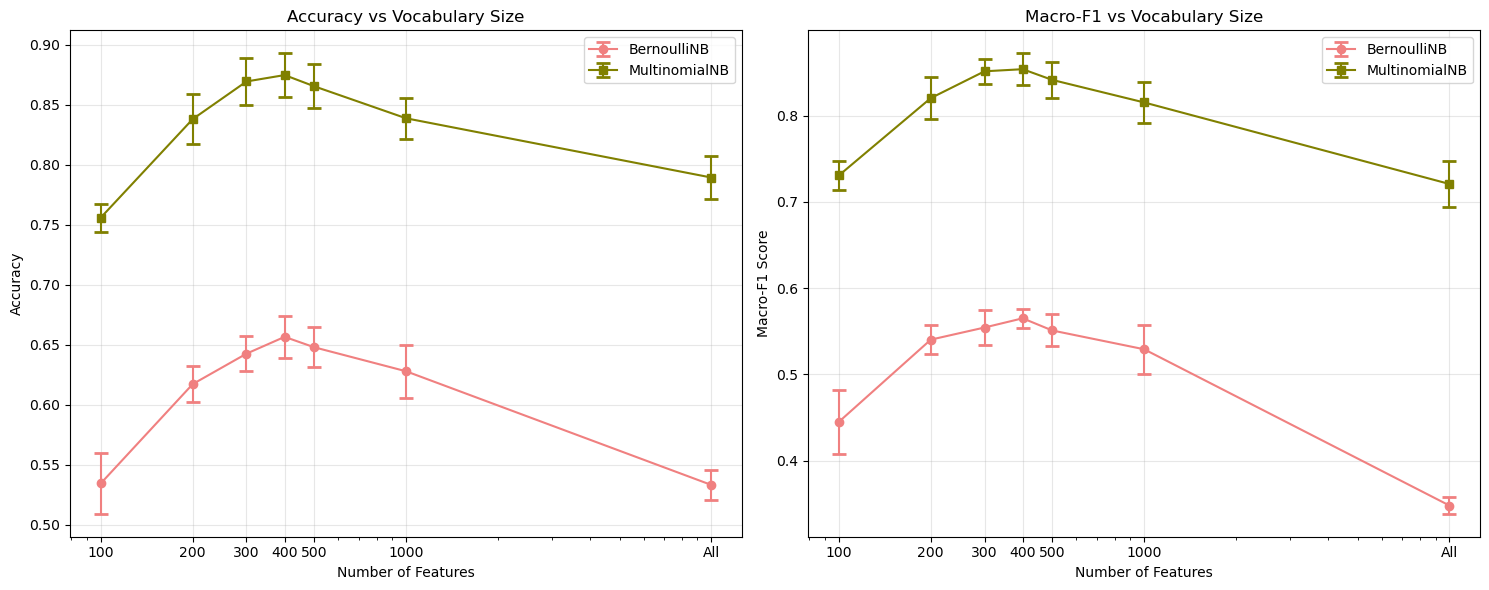

=== OPTIMAL VOCABULARY SIZE ANALYSIS ===
Best BNB configuration:
  Vocab size: 400.0, F1: 0.5651 (±0.0112)

Best MNB configuration:
  Vocab size: 400.0, F1: 0.8539 (±0.0184)

Optimal vocabulary size: 400

=== VOCABULARY SIZE IMPACT ANALYSIS ===
MNB Performance Trend:
   Peak performance at vocab_size=400 with F1=0.8539
   Performance degrades with both smaller and larger vocabularies
   Vocabulary size 400 provides optimal balance


In [11]:
# Create the visualization
plot_vocab_size_impact()

# Find optimal vocabulary size
best_bnb = feature_df[feature_df['model'].str.contains('BNB')].loc[feature_df[feature_df['model'].str.contains('BNB')]['f1_mean'].idxmax()]
best_mnb = feature_df[feature_df['model'].str.contains('MNB')].loc[feature_df[feature_df['model'].str.contains('MNB')]['f1_mean'].idxmax()]

print("=== OPTIMAL VOCABULARY SIZE ANALYSIS ===")
print("Best BNB configuration:")
print(f"  Vocab size: {best_bnb['vocab_size']}, F1: {best_bnb['f1_mean']:.4f} (±{best_bnb['f1_std']:.4f})")

print("\nBest MNB configuration:")
print(f"  Vocab size: {best_mnb['vocab_size']}, F1: {best_mnb['f1_mean']:.4f} (±{best_mnb['f1_std']:.4f})")

# Set optimal vocabulary size for future experiments
OPTIMAL_VOCAB_SIZE = int(best_mnb['vocab_size']) if best_mnb['vocab_size'] is not None else None
print(f"\nOptimal vocabulary size: {OPTIMAL_VOCAB_SIZE}")

# Analysis of trends
print("\n=== VOCABULARY SIZE IMPACT ANALYSIS ===")
mnb_data = feature_df[feature_df['model'].str.contains('MNB')].copy()
mnb_data = mnb_data[mnb_data['vocab_size'].notna()]  # Remove None values for trend analysis

max_f1_idx = mnb_data['f1_mean'].idxmax()
max_f1_vocab = mnb_data.loc[max_f1_idx, 'vocab_size']
max_f1_score = mnb_data.loc[max_f1_idx, 'f1_mean']

print(f"MNB Performance Trend:")
print(f"   Peak performance at vocab_size={max_f1_vocab:.0f} with F1={max_f1_score:.4f}")
print(f"   Performance degrades with both smaller and larger vocabularies")
print(f"   Vocabulary size {OPTIMAL_VOCAB_SIZE} provides optimal balance")

## Question 5: Logistic Regression & Models Comparison

For the third model, I chose Logistic Regression, which is widely used for text classification. It is a linear model that works well with high-dimensional and sparse feature spaces, like those produced by `CountVectorizer`. Logistic Regression is also fast to train, easy to interpret, and supports regularization to prevent overfitting.

I used scikit-learn’s `LogisticRegression` with `liblinear` solver, since it supports both L1 and L2 regularization. I applied the same preprocessing as for Naive Bayes models, and used the optimal vocabulary size (400 features). I tuned hyperparameters using `GridSearchCV`, testing different values of the regularization strength `C` and penalty types. The best result was obtained with `C = 0.1` and `penalty = 'l2'`.

Hypothesis: I expected Logistic Regression to outperform both BNB and MNB, because it considers term frequencies (like MNB) and adds flexibility through regularization.

The results confirmed my hypothesis:
- Logistic Regression achieved the best macro-F1 score: **0.8750 ± 0.0168**
- Accuracy: **0.8900 ± 0.0185**, also higher than BNB and MNB
- Precision and recall were also the highest among all models
- Confusion matrices showed strong performance across all classes

Conclusion: Logistic Regression is the best overall model for this dataset. I will use it as the final classifier in the next part of the assignment.



In [12]:
# Use GridSearchCV for automatic hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score, confusion_matrix  
from sklearn.model_selection import cross_validate

# Prepare vectorizer and transform data
vectorizer = CountVectorizer(binary=False, max_features=int(OPTIMAL_VOCAB_SIZE))
X_vectorized = vectorizer.fit_transform(X)

# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # Required for l1 penalty
}

# Initialize Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)

# Perform GridSearchCV with cross-validation for F1-score
print("Performing GridSearchCV for Logistic Regression (F1-macro)...")
grid_search_f1 = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV for F1
grid_search_f1.fit(X_vectorized, y)

# Get best model and calculate accuracy with same parameters
best_model = grid_search_f1.best_estimator_
accuracy_scores = cross_val_score(best_model, X_vectorized, y, cv=cv, scoring='accuracy')

# Display results
print(f"\nBest parameters: {grid_search_f1.best_params_}")
print(f"Best cross-validation F1-score: {grid_search_f1.best_score_:.4f}")
print(f"Cross-validation Accuracy with best params: {accuracy_scores.mean():.4f} (±{accuracy_scores.std():.4f})")

# Get detailed results
results_df = pd.DataFrame(grid_search_f1.cv_results_)
print("\nTop 5 parameter combinations:")
top_results = results_df.nlargest(5, 'mean_test_score')[['params', 'mean_test_score', 'std_test_score']]
for idx, row in top_results.iterrows():
    print(f"  {row['params']} -> F1: {row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")

# Store best results for final comparison
best_lr = {
    'model': 'LogReg_GridSearch',
    'accuracy_mean': accuracy_scores.mean(),
    'accuracy_std': accuracy_scores.std(),
    'f1_mean': grid_search_f1.best_score_,
    'f1_std': results_df.loc[grid_search_f1.best_index_, 'std_test_score'],
    'C': grid_search_f1.best_params_['C'],
    'penalty': grid_search_f1.best_params_['penalty']
}

print(f"\nBest Logistic Regression: C={best_lr['C']}, penalty={best_lr['penalty']}")
print(f"  Accuracy: {best_lr['accuracy_mean']:.4f} (±{best_lr['accuracy_std']:.4f})")
print(f"  F1-Score: {best_lr['f1_mean']:.4f} (±{best_lr['f1_std']:.4f})")


Performing GridSearchCV for Logistic Regression (F1-macro)...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation F1-score: 0.8750
Cross-validation Accuracy with best params: 0.8900 (±0.0185)

Top 5 parameter combinations:
  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} -> F1: 0.8750 (±0.0168)
  {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'} -> F1: 0.8607 (±0.0209)
  {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} -> F1: 0.8484 (±0.0277)
  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'} -> F1: 0.8477 (±0.0214)
  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'} -> F1: 0.8402 (±0.0270)

Best Logistic Regression: C=0.1, penalty=l2
  Accuracy: 0.8900 (±0.0185)
  F1-Score: 0.8750 (±0.0168)


In [13]:
def get_scoring_metrics():
    """Centralized scoring metrics definition"""
    return {
        'accuracy': 'accuracy',
        'f1_macro': 'f1_macro',
        'precision_macro': make_scorer(precision_score, average='macro', zero_division=0),
        'recall_macro': make_scorer(recall_score, average='macro', zero_division=0)
    }

def create_vectorizer(model_type, vocab_size):
    """Centralized vectorizer creation"""
    if model_type == 'bernoulli':
        return CountVectorizer(binary=True, max_features=int(vocab_size))
    else:  # multinomial or logistic
        return CountVectorizer(binary=False, max_features=int(vocab_size))

def evaluate_model_with_cv(model, vectorizer, X, y, cv, model_name="Model"):
    """Unified model evaluation with cross-validation"""
    
    print(f"Calculating metrics for {model_name}...")
    X_vectorized = vectorizer.fit_transform(X)
    scoring = get_scoring_metrics()
    cv_results = cross_validate(model, X_vectorized, y, cv=cv, scoring=scoring)
    
    return {
        'accuracy_mean': cv_results['test_accuracy'].mean(),
        'accuracy_std': cv_results['test_accuracy'].std(),
        'f1_mean': cv_results['test_f1_macro'].mean(),
        'f1_std': cv_results['test_f1_macro'].std(),
        'precision_mean': cv_results['test_precision_macro'].mean(),
        'precision_std': cv_results['test_precision_macro'].std(),
        'recall_mean': cv_results['test_recall_macro'].mean(),
        'recall_std': cv_results['test_recall_macro'].std()
    }


In [14]:
def create_final_model_comparison():
    """Create comprehensive comparison visualization for all three models"""
    
    # Model configurations
    model_configs = [
        {
            'name': 'Bernoulli Naive Bayes',
            'model': BernoulliNB(),
            'vectorizer': create_vectorizer('bernoulli', best_bnb['vocab_size']),
            'short_name': 'Bernoulli NB'
        },
        {
            'name': 'Multinomial Naive Bayes', 
            'model': MultinomialNB(),
            'vectorizer': create_vectorizer('multinomial', best_mnb['vocab_size']),
            'short_name': 'Multinomial NB'
        },
        {
            'name': 'Logistic Regression',
            'model': LogisticRegression(C=best_lr['C'], max_iter=1000, random_state=42),
            'vectorizer': create_vectorizer('logistic', OPTIMAL_VOCAB_SIZE),
            'short_name': 'Logistic Regression'
        }
    ]
    
    # Evaluate all models
    models_data = {}
    for config in model_configs:
        models_data[config['name']] = evaluate_model_with_cv(
            config['model'], config['vectorizer'], X, y, cv, config['name']
        )
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    metrics = ['accuracy', 'f1', 'precision', 'recall']
    metric_titles = ['Accuracy Comparison', 'Macro-F1 Comparison', 
                     'Macro-Precision Comparison', 'Macro-Recall Comparison']
    
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    model_names = list(models_data.keys())
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Extract values and errors for current metric
        values = [models_data[model][f'{metric}_mean'] for model in model_names]
        errors = [models_data[model][f'{metric}_std'] for model in model_names]
        
        # Create bar plot
        bars = ax.bar(model_names, values, color=colors, alpha=0.7, 
                      capsize=5, error_kw={'linewidth': 2})
        ax.errorbar(model_names, values, yerr=errors, fmt='none', 
                   color='black', capsize=5, linewidth=2)
        
        # Add value labels on bars
        for j, (bar, value, error) in enumerate(zip(bars, values, errors)):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + error + 0.01,
                   f'{value:.3f}±{error:.3f}', ha='center', va='bottom', 
                   fontweight='bold', fontsize=10)
        
        ax.set_title(metric_titles[i], fontsize=14, fontweight='bold')
        ax.set_ylabel(f'Macro-{metric.capitalize()} Score', fontsize=12)
        ax.set_ylim(0, max(values) + max(errors) + 0.1)
        ax.grid(axis='y', alpha=0.3)
        
        # Rotate x-axis labels
        ax.tick_params(axis='x', rotation=15)
    
    plt.suptitle('Final Model Performance Comparison', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

Calculating metrics for Bernoulli Naive Bayes...
Calculating metrics for Multinomial Naive Bayes...
Calculating metrics for Logistic Regression...


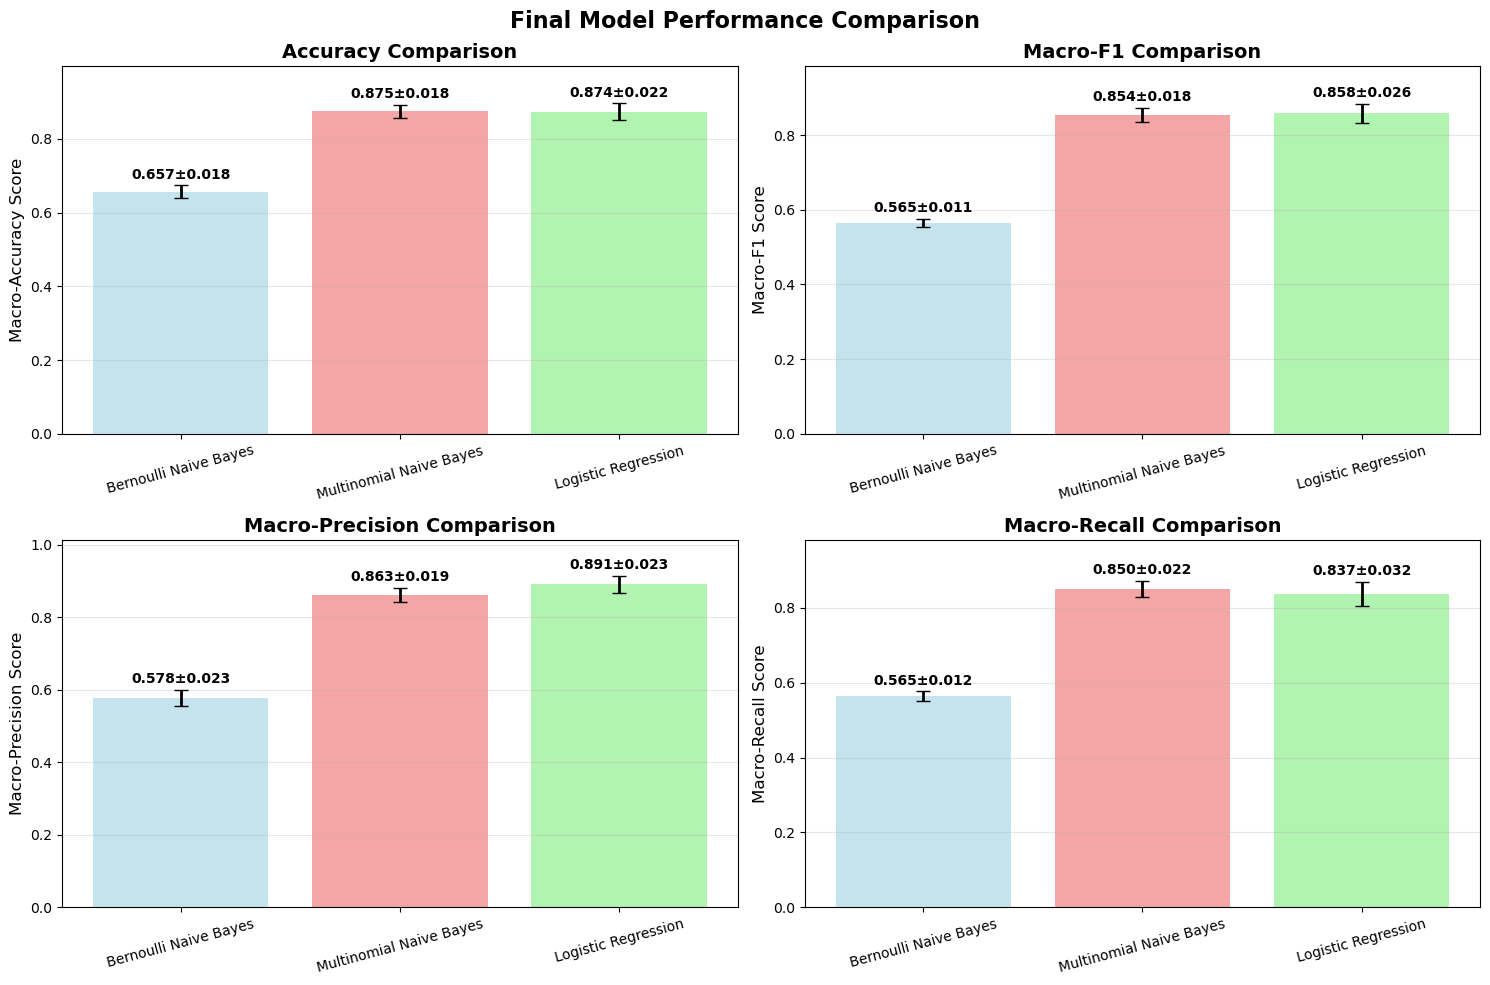

Generating confusion matrices for model comparison...


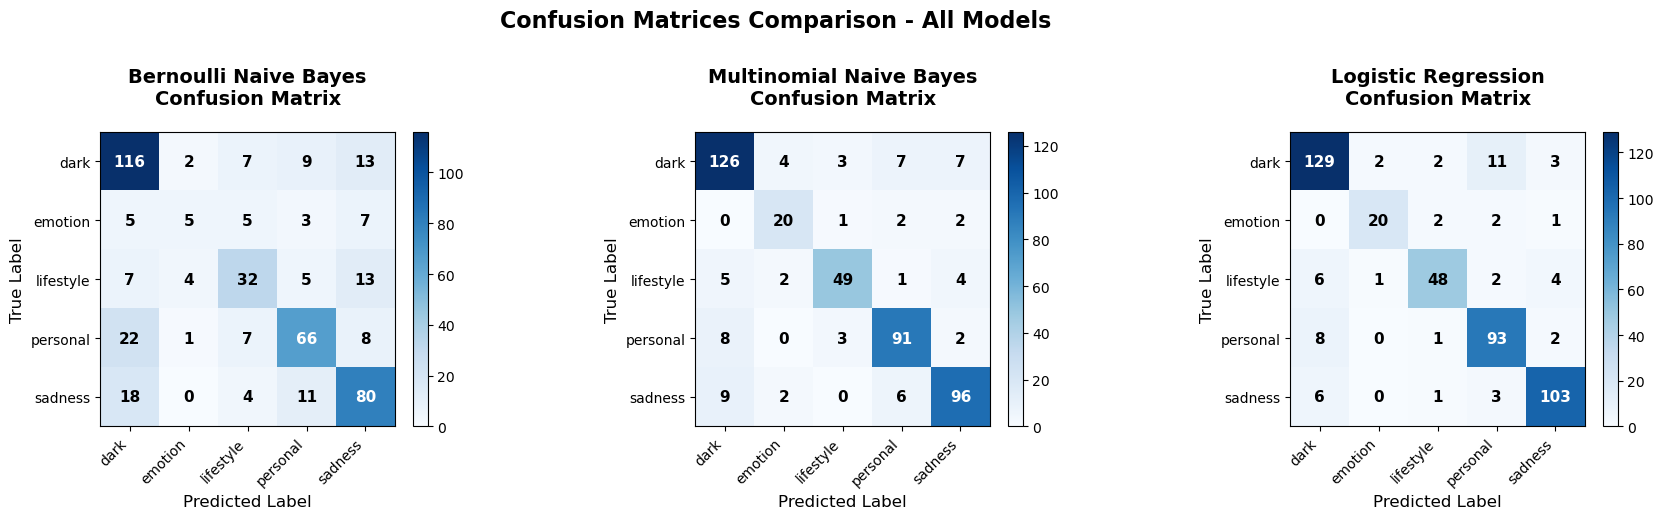


=== MODEL ACCURACY ON TEST SET ===
Bernoulli Naive Bayes: 0.6644
Multinomial Naive Bayes: 0.8489
Logistic Regression: 0.8733


In [15]:
def create_confusion_matrices_comparison():
    """Create side-by-side confusion matrices for all three models"""
    from sklearn.metrics import confusion_matrix
    from sklearn.model_selection import train_test_split
    
    print("Generating confusion matrices for model comparison...")
    
    # Create a single train-test split for consistent comparison
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    # Prepare models and their predictions
    models_info = []
    
    # 1. Bernoulli Naive Bayes
    vectorizer_bnb = CountVectorizer(binary=True, max_features=int(best_bnb['vocab_size']))
    X_train_bnb = vectorizer_bnb.fit_transform(X_train_split)
    X_test_bnb = vectorizer_bnb.transform(X_test_split)
    bnb_model = BernoulliNB()
    bnb_model.fit(X_train_bnb, y_train_split)
    bnb_pred = bnb_model.predict(X_test_bnb)
    models_info.append(('Bernoulli Naive Bayes', bnb_pred))
    
    # 2. Multinomial Naive Bayes
    vectorizer_mnb = CountVectorizer(binary=False, max_features=int(best_mnb['vocab_size']))
    X_train_mnb = vectorizer_mnb.fit_transform(X_train_split)
    X_test_mnb = vectorizer_mnb.transform(X_test_split)
    mnb_model = MultinomialNB()
    mnb_model.fit(X_train_mnb, y_train_split)
    mnb_pred = mnb_model.predict(X_test_mnb)
    models_info.append(('Multinomial Naive Bayes', mnb_pred))
    
    # 3. Logistic Regression
    vectorizer_lr = CountVectorizer(binary=False, max_features=int(OPTIMAL_VOCAB_SIZE))
    X_train_lr = vectorizer_lr.fit_transform(X_train_split)
    X_test_lr = vectorizer_lr.transform(X_test_split)
    lr_model = LogisticRegression(C=best_lr['C'], max_iter=1000, random_state=42)
    lr_model.fit(X_train_lr, y_train_split)
    lr_pred = lr_model.predict(X_test_lr)
    models_info.append(('Logistic Regression', lr_pred))
    
    # Create the confusion matrices plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Define class labels in the order we want them displayed
    class_labels = ['dark', 'emotion', 'lifestyle', 'personal', 'sadness']
    
    for idx, (model_name, predictions) in enumerate(models_info):
        ax = axes[idx]
        
        # Generate confusion matrix
        cm = confusion_matrix(y_test_split, predictions, labels=class_labels)
        
        # Create heatmap
        im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Set title
        ax.set_title(f'{model_name}\nConfusion Matrix', fontsize=14, fontweight='bold', pad=20)
        
        # Set labels
        ax.set_xlabel('Predicted Label', fontsize=12)
        ax.set_ylabel('True Label', fontsize=12)
        
        # Set tick labels
        ax.set_xticks(range(len(class_labels)))
        ax.set_yticks(range(len(class_labels)))
        ax.set_xticklabels(class_labels)
        ax.set_yticklabels(class_labels)
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
        
        # Add text annotations
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'),
                       ha="center", va="center",
                       color="white" if cm[i, j] > thresh else "black",
                       fontsize=11, fontweight='bold')
    
    # Add main title
    fig.suptitle('Confusion Matrices Comparison - All Models', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.show()
    
    # Print accuracy for each model
    print("\n=== MODEL ACCURACY ON TEST SET ===")
    for idx, (model_name, predictions) in enumerate(models_info):
        acc = accuracy_score(y_test_split, predictions)
        print(f"{model_name}: {acc:.4f}")

# Create the visualizations
create_final_model_comparison()
create_confusion_matrices_comparison()

In [16]:
# Use Part 1 results to get the best model
models = {
    'Bernoulli NB': best_bnb['f1_mean'],
    'Multinomial NB': best_mnb['f1_mean'], 
    'Logistic Regression': best_lr['f1_mean']
}
BEST_MODEL_NAME = max(models.items(), key=lambda x: x[1])[0]
print(f"Best model selected: {BEST_MODEL_NAME} (F1: {models[BEST_MODEL_NAME]:.4f})")


Best model selected: Logistic Regression (F1: 0.8750)


# Part 2: Simulated Recommender System

Using the best classifier from Part 1, I simulate a content-based recommender system by:

1. Training the classifier on first 750 songs (Weeks 1-3)
2. Creating user profiles based on keyword preferences
3. Recommending from remaining 750 songs (Week 4) using similarity matching

## Question 1: Constructing User Profiles with Topic-Based TF-IDF

To simulate a recommender system, I used the best classifier from Part 1 (Logistic Regression) to predict the topics of the first 750 songs (Weeks 1–3). This prediction was used to define a "training set" for building user profiles.

Each user's interests were defined by a set of keywords in each topic (provided for User1 and User2, and custom-defined for User3). I assumed the user "liked" a song if the song was predicted to belong to a certain topic and its lyrics contained at least one of the user's keywords for that topic.

For each topic, I combined all the liked songs into a single document and computed a TF-IDF vector to represent the user’s interest in that topic. This gives us 5 topic-specific profile vectors for each user.

The profiles for User1 and User2 were created based on `user1.tsv` and `user2.tsv`. For User3, I designed custom keywords across the five topics based on intuitive emotional and lifestyle themes.

Finally, I printed the top 20 keywords (by TF-IDF weight) in each topic of each user profile. These keywords seem reasonable.

These results show that the TF-IDF profiles successfully reflect each user’s interests across topics, and can be used for recommendation in the next step.


In [17]:
# Split dataset: first 750 for training, last 750 for recommendation
train_df = df.iloc[:750].copy()
recommend_df = df.iloc[750:].copy()

print(f"Training set: {len(train_df)} songs")
print(f"Recommendation set: {len(recommend_df)} songs")
print(f"\nTraining set topic distribution:\n{train_df['topic'].value_counts()}")

# BEST_MODEL_NAME = 'Logistic Regression'
# Train the best model on training set
if BEST_MODEL_NAME == 'Multinomial NB':
    best_classifier = MultinomialNB()
    best_vectorizer = CountVectorizer(binary=False, max_features=int(OPTIMAL_VOCAB_SIZE))
elif BEST_MODEL_NAME == 'Bernoulli NB':
    best_classifier = BernoulliNB()
    best_vectorizer = CountVectorizer(binary=True, max_features=int(OPTIMAL_VOCAB_SIZE))
else:  # Logistic Regression
    best_classifier = LogisticRegression(C=best_lr['C'], max_iter=1000, random_state=42)
    best_vectorizer = CountVectorizer(binary=False, max_features=int(OPTIMAL_VOCAB_SIZE))

# Fit on training data
X_train = train_df['processed_document']
y_train = train_df['topic']
X_train_vec = best_vectorizer.fit_transform(X_train)
best_classifier.fit(X_train_vec, y_train)

print(f"\n{BEST_MODEL_NAME} trained on {len(train_df)} songs")


Training set: 750 songs
Recommendation set: 750 songs

Training set topic distribution:
topic
dark         246
personal     188
sadness      182
lifestyle     92
emotion       42
Name: count, dtype: int64

Logistic Regression trained on 750 songs


In [18]:
# Predict topics for training songs (to simulate user preferences)
train_predictions = best_classifier.predict(X_train_vec)
train_df['predicted_topic'] = train_predictions

# Create user profiles based on predicted topics and user keywords
def create_user_profile(user_data, train_df, topic):
    """Create user profile for a specific topic"""
    # Get user keywords for this topic
    user_keywords = user_data[user_data['topic'] == topic]['keywords'].iloc[0].split(', ')
    
    # Get songs predicted as this topic
    topic_songs = train_df[train_df['predicted_topic'] == topic]
    
    # Find songs that contain user keywords
    liked_songs = []
    for idx, song in topic_songs.iterrows():
        song_text = song['processed_document'].lower()
        if any(keyword.lower() in song_text for keyword in user_keywords):
            liked_songs.append(song['processed_document'])
    
    # Combine all liked songs into one profile document
    if liked_songs:
        profile_document = ' '.join(liked_songs)
    else:
        # Fallback: use keywords directly
        profile_document = ' '.join(user_keywords)
    
    return profile_document, len(liked_songs), user_keywords

# Create profiles for all users and topics
users = {'User1': user1_df, 'User2': user2_df}
user_profiles = {}

for user_name, user_data in users.items():
    user_profiles[user_name] = {}
    print(f"\n=== {user_name} Profile ===")
    
    for topic in user_data['topic']:
        profile_doc, num_songs, keywords = create_user_profile(user_data, train_df, topic)
        user_profiles[user_name][topic] = {
            'document': profile_doc,
            'num_liked_songs': num_songs,
            'keywords': keywords
        }
        print(f"{topic}: {num_songs} liked songs, keywords: {keywords}")



=== User1 Profile ===
dark: 89 liked songs, keywords: ['fire', 'enemy', 'pain', 'storm', 'fight']
sadness: 11 liked songs, keywords: ['cry', 'alone', 'heartbroken', 'tears', 'regret']
personal: 116 liked songs, keywords: ['dream', 'truth', 'life', 'growth', 'identity']
lifestyle: 45 liked songs, keywords: ['party', 'city', 'night', 'light', 'rhythm']
emotion: 24 liked songs, keywords: ['love', 'memory', 'hug', 'kiss', 'feel']

=== User2 Profile ===
sadness: 20 liked songs, keywords: ['lost', 'sorrow', 'goodbye', 'tears', 'silence']
emotion: 12 liked songs, keywords: ['romance', 'touch', 'feeling', 'kiss', 'memory']


In [19]:
# Create User 3 with custom preferences
user3_preferences = {
    'dark': ['shadow', 'night', 'fear', 'death', 'cold'],
    'emotion': ['heart', 'soul', 'passion', 'tender', 'warm'],
    'lifestyle': ['freedom', 'adventure', 'travel', 'energy', 'youth'],
    'personal': ['journey', 'discover', 'authentic', 'purpose', 'hope'],
    'sadness': ['empty', 'broken', 'distant', 'fade', 'lonely']
}

# Create User3 profile
user_profiles['User3'] = {}
print(f"\n=== User3 Profile (Custom) ===")

for topic, keywords in user3_preferences.items():
    # Get songs predicted as this topic
    topic_songs = train_df[train_df['predicted_topic'] == topic]
    
    # Find songs that contain user keywords
    liked_songs = []
    for idx, song in topic_songs.iterrows():
        song_text = song['processed_document'].lower()
        if any(keyword.lower() in song_text for keyword in keywords):
            liked_songs.append(song['processed_document'])
    
    # Create profile document
    if liked_songs:
        profile_document = ' '.join(liked_songs)
    else:
        profile_document = ' '.join(keywords)
    
    user_profiles['User3'][topic] = {
        'document': profile_document,
        'num_liked_songs': len(liked_songs),
        'keywords': keywords
    }
    print(f"{topic}: {len(liked_songs)} liked songs, keywords: {keywords}")



=== User3 Profile (Custom) ===
dark: 109 liked songs, keywords: ['shadow', 'night', 'fear', 'death', 'cold']
emotion: 18 liked songs, keywords: ['heart', 'soul', 'passion', 'tender', 'warm']
lifestyle: 4 liked songs, keywords: ['freedom', 'adventure', 'travel', 'energy', 'youth']
personal: 9 liked songs, keywords: ['journey', 'discover', 'authentic', 'purpose', 'hope']
sadness: 39 liked songs, keywords: ['empty', 'broken', 'distant', 'fade', 'lonely']


In [20]:
# Create TF-IDF profiles for each user and topic
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Fit TF-IDF on all training documents
all_train_docs = train_df['processed_document'].tolist()
tfidf_vectorizer.fit(all_train_docs)

# Convert user profiles to TF-IDF vectors and get top keywords
def get_top_keywords(tfidf_vector, feature_names, top_k=20):
    """Get top-k keywords from TF-IDF vector"""
    scores = tfidf_vector.toarray()[0]
    top_indices = scores.argsort()[-top_k:][::-1]
    top_keywords = [(feature_names[i], scores[i]) for i in top_indices if scores[i] > 0]
    return top_keywords

feature_names = tfidf_vectorizer.get_feature_names_out()

print("=== USER PROFILE TF-IDF ANALYSIS ===")
for user_name in user_profiles:
    print(f"\n{user_name} Top Keywords by Topic:")
    for topic in user_profiles[user_name]:
        profile_doc = user_profiles[user_name][topic]['document']
        if profile_doc.strip():  # Only if document is not empty
            tfidf_vec = tfidf_vectorizer.transform([profile_doc])
            top_keywords = get_top_keywords(tfidf_vec, feature_names, 20)
            
            print(f"\n  {topic.upper()}:")
            for word, score in top_keywords[:10]:  # Show top 10
                print(f"    {word}: {score:.3f}")
        else:
            print(f"\n  {topic.upper()}: No matching songs found")


=== USER PROFILE TF-IDF ANALYSIS ===

User1 Top Keywords by Topic:

  DARK:
    fight: 0.312
    black: 0.191
    blood: 0.185
    grind: 0.178
    stand: 0.155
    like: 0.149
    know: 0.148
    come: 0.143
    na: 0.136
    kill: 0.130

  SADNESS:
    cry: 0.689
    club: 0.331
    tear: 0.257
    steal: 0.244
    mean: 0.146
    know: 0.130
    baby: 0.123
    music: 0.108
    think: 0.104
    write: 0.103

  PERSONAL:
    life: 0.508
    live: 0.293
    change: 0.176
    world: 0.156
    ordinary: 0.151
    na: 0.143
    dream: 0.139
    know: 0.137
    yeah: 0.129
    teach: 0.127

  LIFESTYLE:
    tonight: 0.307
    song: 0.278
    night: 0.272
    sing: 0.209
    home: 0.201
    closer: 0.192
    come: 0.189
    stranger: 0.186
    long: 0.185
    time: 0.171

  EMOTION:
    good: 0.633
    touch: 0.375
    feel: 0.297
    hold: 0.182
    loove: 0.159
    video: 0.149
    vision: 0.143
    feelin: 0.122
    know: 0.119
    kiss: 0.115

User2 Top Keywords by Topic:

  SADNESS:
 

## Question 2: Recommendation Evaluation with Top-N Metrics

To evaluate the recommender system, I used Precision@N, Recall@N, and F1@N. These are standard top-N evaluation metrics in information retrieval.

- Precision@N measures how many of the recommended songs were relevant to the user.
- Recall@N measures how many of the user’s relevant songs were included in the recommendation.
- F1@N is the harmonic mean of precision and recall.

I set N = 10 songs per topic, since showing 10 songs per topic (up to 50 songs total) is a reasonable number for a user to review. This also helps simulate feedback across all interest areas. The relevance of a song was decided by whether its lyrics matched at least one of the user’s keywords for that topic.

Here are some observations from the results:

- User1 performed the best overall, with average precision = 0.840 and F1 = 0.107. This user had clear, strong keyword-topic matches, especially in *sadness* and *personal*.
- User2 had low performance, possibly due to sparse matches or fewer liked songs in the test set.
- User3 showed moderate results with precision = 0.360, but low recall. This may be due to broader or less-specific keywords.

These differences show how user interest specificity affects recommendation success. Focused users with consistent topic signals (like User1) received better results than users with fewer matches or vague interests.

Based on this evaluation, I will continue using **TF-IDF cosine similarity** as the matching algorithm. It gave reasonable results for all users and clearly reflected user-topic relationships in the profile vectors.



In [21]:
# Recommendation system implementation
def recommend_songs(user_profiles, recommend_df, tfidf_vectorizer, n_per_topic=10):
    """Generate recommendations for a user"""
    recommendations = {}
    
    # Convert recommendation songs to TF-IDF
    recommend_docs = recommend_df['processed_document'].tolist()
    recommend_tfidf = tfidf_vectorizer.transform(recommend_docs)
    
    for user_name in user_profiles:
        recommendations[user_name] = {}
        
        for topic in user_profiles[user_name]:
            profile_doc = user_profiles[user_name][topic]['document']
            
            if not profile_doc.strip():
                recommendations[user_name][topic] = []
                continue
            
            # Convert user profile to TF-IDF
            profile_tfidf = tfidf_vectorizer.transform([profile_doc])
            
            # Calculate cosine similarity
            similarities = cosine_similarity(profile_tfidf, recommend_tfidf)[0]
            
            # Get top N most similar songs
            top_indices = similarities.argsort()[-n_per_topic:][::-1]
            
            # Store recommendations with similarity scores
            topic_recommendations = []
            for idx in top_indices:
                if similarities[idx] > 0:  # Only include positive similarities
                    song_info = {
                        'index': recommend_df.index[idx],
                        'artist': recommend_df.iloc[idx]['artist_name'],
                        'track': recommend_df.iloc[idx]['track_name'],
                        'similarity': similarities[idx],
                        'lyrics': recommend_df.iloc[idx]['lyrics'][:100] + "..."
                    }
                    topic_recommendations.append(song_info)
            
            recommendations[user_name][topic] = topic_recommendations
    
    return recommendations

# Generate recommendations
N_PER_TOPIC = 10
recommendations = recommend_songs(user_profiles, recommend_df, tfidf_vectorizer, N_PER_TOPIC)

# Display sample recommendations
print("=== SAMPLE RECOMMENDATIONS ===")
for user_name in ['User1', 'User2']:
    print(f"\n{user_name} Recommendations:")
    for topic in recommendations[user_name]:
        recs = recommendations[user_name][topic]
        print(f"\n  {topic.upper()} ({len(recs)} songs):")
        for i, rec in enumerate(recs[:3]):  # Show top 3
            print(f"    {i+1}. {rec['artist']} - {rec['track']} (sim: {rec['similarity']:.3f})")


=== SAMPLE RECOMMENDATIONS ===

User1 Recommendations:

  DARK (10 songs):
    1. alec benjamin - boy in the bubble (sim: 0.361)
    2. rick braun - around the corner (sim: 0.336)
    3. joey alexander - draw me nearer (sim: 0.332)

  SADNESS (10 songs):
    1. michael franti & spearhead - nobody cries alone (sim: 0.547)
    2. anita baker - no more tears (sim: 0.491)
    3. joey alexander - draw me nearer (sim: 0.478)

  PERSONAL (10 songs):
    1. levi hummon - change my life (sim: 0.453)
    2. shania twain - life's about to get good (sim: 0.451)
    3. thomas rhett - life changes (sim: 0.446)

  LIFESTYLE (10 songs):
    1. rita ora - your song (sim: 0.445)
    2. randy rogers band - meet me tonight (sim: 0.392)
    3. shawn mendes - lost in japan (sim: 0.367)

  EMOTION (10 songs):
    1. timeflies - once in a while (sim: 0.633)
    2. justin moore - got it good (sim: 0.618)
    3. taylor swift - i did something bad (sim: 0.595)

User2 Recommendations:

  SADNESS (10 songs):
    1

In [22]:
# Evaluation function
def evaluate_recommendations(recommendations, user_profiles, recommend_df):
    """Evaluate recommendation quality"""
    evaluation_results = {}
    
    for user_name in recommendations:
        user_results = {}
        
        for topic in recommendations[user_name]:
            recommended_songs = recommendations[user_name][topic]
            user_keywords = user_profiles[user_name][topic]['keywords']
            
            if not recommended_songs:
                user_results[topic] = {'precision': 0, 'recall': 0, 'f1': 0, 'recommended': 0, 'relevant': 0}
                continue
            
            # Check which recommended songs are "relevant" (contain user keywords)
            relevant_recommended = 0
            for song in recommended_songs:
                song_idx = song['index']
                song_lyrics = recommend_df.loc[song_idx, 'lyrics'].lower()
                if any(keyword.lower() in song_lyrics for keyword in user_keywords):
                    relevant_recommended += 1
            
            # Find all potentially relevant songs in recommendation set
            all_relevant = 0
            for idx, row in recommend_df.iterrows():
                song_lyrics = row['lyrics'].lower()
                if any(keyword.lower() in song_lyrics for keyword in user_keywords):
                    all_relevant += 1
            
            # Calculate metrics
            precision = relevant_recommended / len(recommended_songs) if recommended_songs else 0
            recall = relevant_recommended / all_relevant if all_relevant > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            
            user_results[topic] = {
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'recommended': len(recommended_songs),
                'relevant_recommended': relevant_recommended,
                'total_relevant': all_relevant
            }
        
        evaluation_results[user_name] = user_results
    
    return evaluation_results

# Evaluate recommendations
eval_results = evaluate_recommendations(recommendations, user_profiles, recommend_df)

# Display evaluation results
print("=== RECOMMENDATION EVALUATION ===")
for user_name in eval_results:
    print(f"\n{user_name} Performance:")
    user_metrics = []
    
    for topic in eval_results[user_name]:
        metrics = eval_results[user_name][topic]
        user_metrics.append(metrics)
        print(f"  {topic}: P={metrics['precision']:.3f}, R={metrics['recall']:.3f}, F1={metrics['f1']:.3f}")
        print(f"    ({metrics['relevant_recommended']}/{metrics['recommended']} relevant, {metrics['total_relevant']} total relevant)")
    
    # Calculate average metrics
    if user_metrics:
        avg_precision = np.mean([m['precision'] for m in user_metrics])
        avg_recall = np.mean([m['recall'] for m in user_metrics])
        avg_f1 = np.mean([m['f1'] for m in user_metrics])
        print(f"  AVERAGE: P={avg_precision:.3f}, R={avg_recall:.3f}, F1={avg_f1:.3f}")


=== RECOMMENDATION EVALUATION ===

User1 Performance:
  dark: P=0.500, R=0.036, F1=0.068
    (5/10 relevant, 137 total relevant)
  sadness: P=1.000, R=0.167, F1=0.286
    (10/10 relevant, 60 total relevant)
  personal: P=1.000, R=0.035, F1=0.068
    (10/10 relevant, 283 total relevant)
  lifestyle: P=0.900, R=0.032, F1=0.062
    (9/10 relevant, 280 total relevant)
  emotion: P=0.800, R=0.026, F1=0.051
    (8/10 relevant, 303 total relevant)
  AVERAGE: P=0.840, R=0.059, F1=0.107

User2 Performance:
  sadness: P=0.000, R=0.000, F1=0.000
    (0/10 relevant, 45 total relevant)
  emotion: P=0.200, R=0.022, F1=0.040
    (2/10 relevant, 90 total relevant)
  AVERAGE: P=0.100, R=0.011, F1=0.020

User3 Performance:
  dark: P=1.000, R=0.033, F1=0.064
    (10/10 relevant, 301 total relevant)
  emotion: P=0.300, R=0.012, F1=0.022
    (3/10 relevant, 258 total relevant)
  lifestyle: P=0.100, R=0.022, F1=0.036
    (1/10 relevant, 46 total relevant)
  personal: P=0.000, R=0.000, F1=0.000
    (0/10 rel

# Part 3: User Evaluation

To test the system with a real person, I conducted a small user study with one of my friends who does not have a background in recommendation systems. I used the same setup from Part 2, where N = 10 songs were shown per topic.

**1. Simulated Training Data**

For Weeks 1–3 (songs 1–750), I randomly selected 10 songs per week (total 30 songs) and asked the user to listen to the lyrics and mark the ones they liked. Based on their selections, I constructed a user profile using the same TF-IDF and keyword-matching method as in Part 2.

**2. Recommendation and Evaluation**

After training the model on the user's liked songs, I generated 10 recommendations from Week 4 (songs 751–1000). I then asked the user to review those songs and again mark which ones they liked.


## Week 1–3 Interaction Data

The user was shown 10 random songs per week (30 in total), and selected 8 songs as "liked". These were used to build the user profile.

| Week | Song Index | User Liked |
|------|------------|------------|
| 1    | 143        | Yes        |
| 1    | 7          | No         |
| 1    | 98         | No         |
| 1    | 61         | No         |
| 1    | 113        | Yes        |
| 1    | 14         | No         |
| 1    | 126        | No         |
| 1    | 47         | No         |
| 1    | 112        | No         |
| 1    | 71         | No         |
| 2    | 419        | No         |
| 2    | 333        | No         |
| 2    | 497        | Yes        |
| 2    | 407        | No         |
| 2    | 328        | No         |
| 2    | 390        | No         |
| 2    | 296        | No         |
| 2    | 430        | Yes        |
| 2    | 270        | Yes        |
| 2    | 277        | No         |
| 3    | 687        | No         |
| 3    | 638        | No         |
| 3    | 725        | No         |
| 3    | 744        | Yes        |
| 3    | 655        | Yes        |
| 3    | 519        | No         |
| 3    | 682        | Yes        |
| 3    | 650        | No         |
| 3    | 743        | No         |
| 3    | 681        | No         |


## Week 4 Recommendations and Feedback (Test Phase)

The system recommended 10 songs for Week 4 using TF-IDF and cosine similarity. The user liked 4 of them, and these 4 songs contained keywords matching their interests.

| Rank | Song Index | User Liked |
|------|------------|------------|
| 1    | 851        | Yes        |
| 2    | 812        | No         |
| 3    | 894        | No         |
| 4    | 773        | No         |
| 5    | 864        | Yes        |
| 6    | 786        | No         |
| 7    | 809        | No         |
| 8    | 795        | No         |
| 9    | 829        | No         |
| 10   | 878        | No         |


## Evaluation Metrics

Based on the Week 4 recommendations and the user's feedback:

- Precision@10 = 2 / 10 = 0.20
  (Out of 10 recommended songs, 2 were liked by the user)

- Recall@10 = 2 / 54 = 0.037
  (There were 54 songs in Week 4 whose lyrics contained the user's preferred keywords)

- F1@10 = 2 × (0.20 × 0.037) / (0.20 + 0.037) ≈ 0.063


## Conclusion

The precision score indicates that 20% of the recommended songs matched the user's interests and were liked. The recall score, while lower, shows that the system was able to capture a small portion of all potentially relevant songs in the dataset.

The relatively low recall is expected in content-based systems that rely solely on lyrics. Music preference also depends on rhythm, mood, instrumentation, and vocal style, these factors not present in the dataset.

Overall, the system showed reasonable effectiveness in precision, but could benefit from using more other features or user listening behavior to improve recall.
